In [2]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 34.4 MB/s eta 0:00:00


In [3]:
import os
import cv2
import torch
import faiss
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [4]:
import torch
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor
import matplotlib.pyplot as plt
import numpy as np

In [55]:
# Load a pre-trained model for feature extraction (ResNet)
model = models.resnet50(pretrained=True)
model.eval()
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
def extract_features(image):
    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif not isinstance(image, Image.Image):
        image = Image.fromarray(image)

    image = Image.fromarray(image)  # Convert to PIL Image
    image = transform(image)  # Apply transform to PIL Image
    image = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()
# Directory containing image folders
image_base_path = '/content/drive/MyDrive/Profane_image'
# Load the index from disk
index = faiss.read_index("/content/drive/MyDrive/Recent Vector Database/image_index_recent.faiss")
image_classes = np.load("/content/drive/MyDrive/Recent Vector Database/image_classes_recent.npy").tolist()
image_paths = np.load("/content/drive/MyDrive/Recent Vector Database/image_paths_recent.npy").tolist()
class_labels = {'Addiction': 0, 'Harassment,Exploitation and Bullying': 1, 'Hentai_Nudity': 2, 'Neutral': 3, 'Religious_Political': 4, 'Sports and Entertainment': 5, 'Suicides_Accidents': 6, 'Terrorism': 7}
# Function to search for similar images and assign class
def search_and_classify(query_image_path, threshold=0.8, k=5):
    query_features = extract_features(query_image_path)
    query_features = query_features.reshape(1, -1)
    faiss.normalize_L2(query_features)  # Normalize query vector to unit length
    distances, indices = index.search(query_features, k)

    # Debugging information
    print(f"Query features shape: {query_features.shape}")
    print(f"Distances: {distances}")
    print(f"Indices: {indices}")

    # Ensure indices are within the valid range
    valid_indices = [i for i in indices[0] if i < len(image_paths)]
    similar_images = [image_paths[i] for i in valid_indices]
    similar_classes = [image_classes[i] for i in valid_indices]

    print(f"Similar images: {similar_images}")
    print(f"Similar classes: {similar_classes}")

    if len(distances[0]) > 0 and distances[0][0] >= threshold:
      assigned_class = similar_classes[0]
      predicted_class = list(class_labels.keys())[list(class_labels.values()).index(assigned_class)]
      print(f"Assigned class:", predicted_class, "with similarity score:", distances[0][0])
      if predicted_class == 'Addiction' or predicted_class == 'Harassment,Exploitation and Bullying' or predicted_class == 'Hentai_Nudity' or predicted_class == 'Religious_Political' or predicted_class == 'Suicides_Accidents' or predicted_class == 'Terrorism':
        print('The image is profane and not allowed to post')
      else:
        print('You can post image')

    else:
      print('It is passed into LLM model')
      # Load the fine-tuned model and image processor
      model_path = "/content/drive/MyDrive/fine-tuned-vit-8.0"
      model = ViTForImageClassification.from_pretrained(model_path)
      image_processor = ViTImageProcessor.from_pretrained(model_path)

      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      model.to(device)
      model.eval()

      # Define the class names
      class_names = ['Addiction','Harassment,Exploitation and Bullying', 'Hentai_Nudity', 'Neutral', 'Religious_Political','Sports and Entertainment','Suicides_Accidents','Terrorism']

      # Function to preprocess and predict
      def predict_image(query_image_path):
          # Load and preprocess the image
          image = Image.open(query_image_path).convert("RGB")
          inputs = image_processor(images=image, return_tensors="pt")

          # Move inputs to the appropriate device
          inputs = {k: v.to(device) for k, v in inputs.items()}

          # Make predictions
          with torch.no_grad():
              outputs = model(**inputs)
              logits = outputs.logits
              predicted_class_idx = logits.argmax(-1).item()

          return predicted_class_idx, logits

      # Predict the image
      predicted_class_idx, logits = predict_image(query_image_path)
      predicted_class = class_names[predicted_class_idx]
      print('Assigned Class:',predicted_class)
      if predicted_class == 'Addiction' or predicted_class == 'Harassment,Exploitation and Bullying' or predicted_class == 'Hentai_Nudity' or predicted_class == 'Religious_Political' or predicted_class == 'Suicides_Accidents' or predicted_class == 'Terrorism':
        print('The image is profane and not allowed to post')
      else:
        print('You can post image')

      # Display the image and prediction
      image = Image.open(query_image_path)
      plt.imshow(image)
      plt.title(f'Predicted: {predicted_class}')
      plt.axis('off')
      plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Query features shape: (1, 1000)
Distances: [[0.7619004  0.6951308  0.6572666  0.62940806 0.62695146]]
Indices: [[ 754  888  496  785 1989]]
Similar images: ['/content/drive/MyDrive/Profane_image/Neutral/download (10).jpg', '/content/drive/MyDrive/Profane_image/Neutral/images (13).jpg', '/content/drive/MyDrive/Profane_image/Religious_Political/istockphoto-1400662945-612x612.png', '/content/drive/MyDrive/Profane_image/Neutral/download (6).jpeg', '/content/drive/MyDrive/Profane_image/Terrorism/images (68).jpeg']
Similar classes: [3, 3, 4, 3, 7]
It is passed into LLM model
Assigned Class: Neutral
You can post image


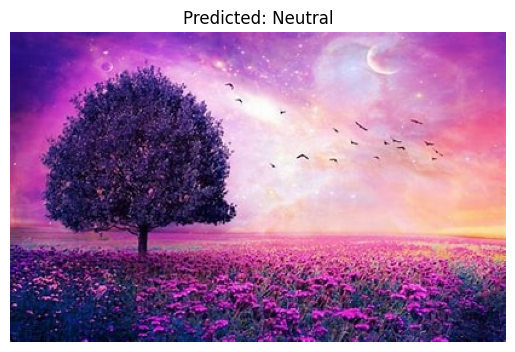

In [56]:
query_image ='/content/aug_1_gettyimages-155419345-612x612.jpg'
assigned_class = search_and_classify(query_image)

In [57]:
search_and_classify('/content/OIP (1).jpg')

Query features shape: (1, 1000)
Distances: [[0.8324593  0.82215476 0.8198186  0.8170314  0.8094134 ]]
Indices: [[791 931 747 920 896]]
Similar images: ['/content/drive/MyDrive/Profane_image/Neutral/download (8).jpg', '/content/drive/MyDrive/Profane_image/Neutral/images (37).jpeg', '/content/drive/MyDrive/Profane_image/Neutral/download (12).jpg', '/content/drive/MyDrive/Profane_image/Neutral/images (23).jpeg', '/content/drive/MyDrive/Profane_image/Neutral/images (16).jpg']
Similar classes: [3, 3, 3, 3, 3]
Assigned class: Neutral with similarity score: 0.8324593
You can post image


In [58]:
search_and_classify('/content/OIP (1).jpeg')

Query features shape: (1, 1000)
Distances: [[0.9748695 0.8679676 0.861341  0.8374901 0.7871026]]
Indices: [[1101 1271 1268 1285 1107]]
Similar images: ['/content/drive/MyDrive/Profane_image/Sports and Entertainment/39.jpeg', '/content/drive/MyDrive/Profane_image/Sports and Entertainment/aug_2_39.jpeg', '/content/drive/MyDrive/Profane_image/Sports and Entertainment/aug_0_39.jpeg', '/content/drive/MyDrive/Profane_image/Sports and Entertainment/aug_1_39.jpeg', '/content/drive/MyDrive/Profane_image/Sports and Entertainment/2 (4).jpeg']
Similar classes: [5, 5, 5, 5, 5]
Assigned class: Sports and Entertainment with similarity score: 0.9748695
You can post image


Query features shape: (1, 1000)
Distances: [[0.79675394 0.79147893 0.7872627  0.7427512  0.7368099 ]]
Indices: [[ 580  735   91 2203  674]]
Similar images: ['/content/drive/MyDrive/Profane_image/Neutral/2 (24).jpeg', '/content/drive/MyDrive/Profane_image/Neutral/augmented_images (58)_0_299.jpg', '/content/drive/MyDrive/Profane_image/Religious_Political/2 (49).jpeg', '/content/drive/MyDrive/Profane_image/Suicides_Accidents/aug_0_images (70).jpg', '/content/drive/MyDrive/Profane_image/Neutral/augmented_images (25)_0_1189.jpg']
Similar classes: [3, 3, 4, 6, 3]
It is passed into LLM model
Assigned Class: Neutral
You can post image


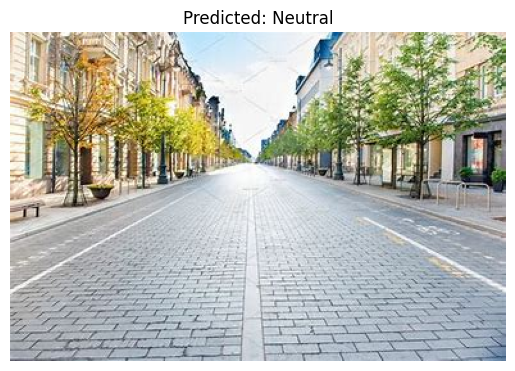

In [59]:
search_and_classify('/content/OIP (6).jpg')

In [61]:
search_and_classify('/content/OIP (5).jpg')

Query features shape: (1, 1000)
Distances: [[0.834396   0.7892486  0.77228314 0.7533625  0.7401118 ]]
Indices: [[2616 2865 3046 1111 3887]]
Similar images: ['/content/drive/MyDrive/Profane_image/Addiction/2 (10).png', '/content/drive/MyDrive/Profane_image/Addiction/download (9).png', '/content/drive/MyDrive/Profane_image/Addiction/istockphoto-868488148-612x612.png', '/content/drive/MyDrive/Profane_image/Sports and Entertainment/29.jpeg', '/content/drive/MyDrive/Profane_image/Harassment,Exploitation and Bullying/images (20).jpeg']
Similar classes: [0, 0, 0, 5, 1]
Assigned class: Addiction with similarity score: 0.834396
The image is profane and not allowed to post


In [65]:
search_and_classify('/content/2 (28).jpg')

Query features shape: (1, 1000)
Distances: [[0.9999998  0.9242791  0.8614106  0.7600598  0.70904946]]
Indices: [[2099 2257 2389  885  723]]
Similar images: ['/content/drive/MyDrive/Profane_image/Suicides_Accidents/2 (28).jpg', '/content/drive/MyDrive/Profane_image/Suicides_Accidents/aug_1_download (29).jpg', '/content/drive/MyDrive/Profane_image/Suicides_Accidents/download (29).jpg', '/content/drive/MyDrive/Profane_image/Neutral/images (12).jpg', '/content/drive/MyDrive/Profane_image/Neutral/augmented_images (56)_0_778.jpg']
Similar classes: [6, 6, 6, 3, 3]
Assigned class: Suicides_Accidents with similarity score: 0.9999998
The image is profane and not allowed to post
